In [8]:
import numpy as np
from os import listdir
import cv2
from matplotlib import pyplot as plt

#matplotlib configs for jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# colour segmentation of the crops.

## Chosen Nomenclature
For ease of use the naming conventions for this notebook will be described here. 
* the 6 rows will be referred to as row_0, row_1, ... row_5 where row_0 is the furthest row in the negative y direction.
* the 3 crop types will be referred to as crop_0, crop_1, and crop_2 where crop_0 is the crop in row_0 and row_1, crop_1 is the crop in row_2 and row_3, and crop_2 is the crop in row_4 and row_5.

In [143]:
images = [file for file in listdir("kinect_images")]
#for testing a smaller set of crop images
# images = ['row_0_326190000000.jpg','row_1_354035000000.jpg','row_2_32450000000.jpg',
#           'row_3_427990000000.jpg','row_4_149530000000.jpg','row_5_92140000000.jpg'] 

row_3_428755000000.jpg


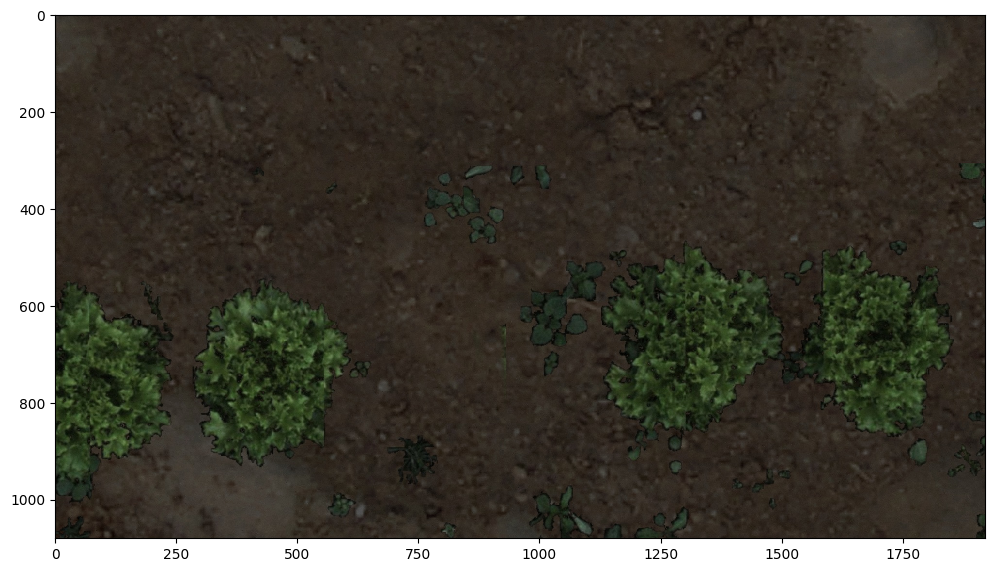

imaged masked to include only plant material


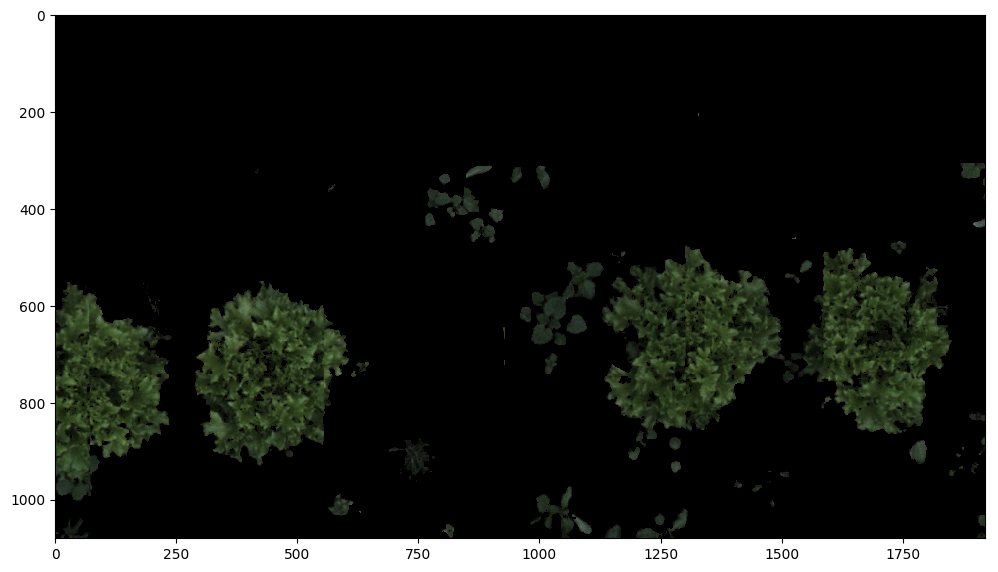

image masked to differentiate between the crop_0 and other plants


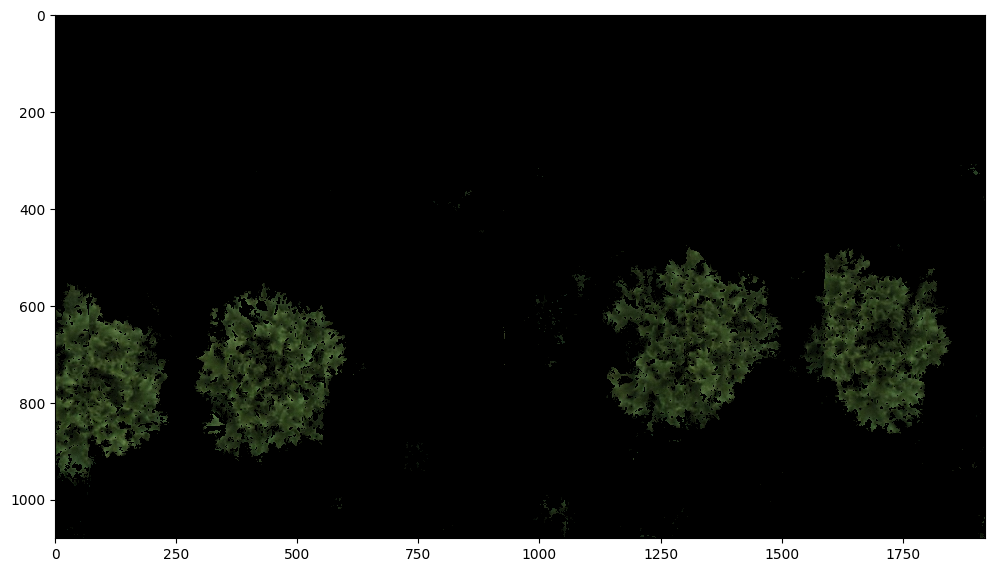

image masked to differentiate between the weeds, and other crops except crop_2


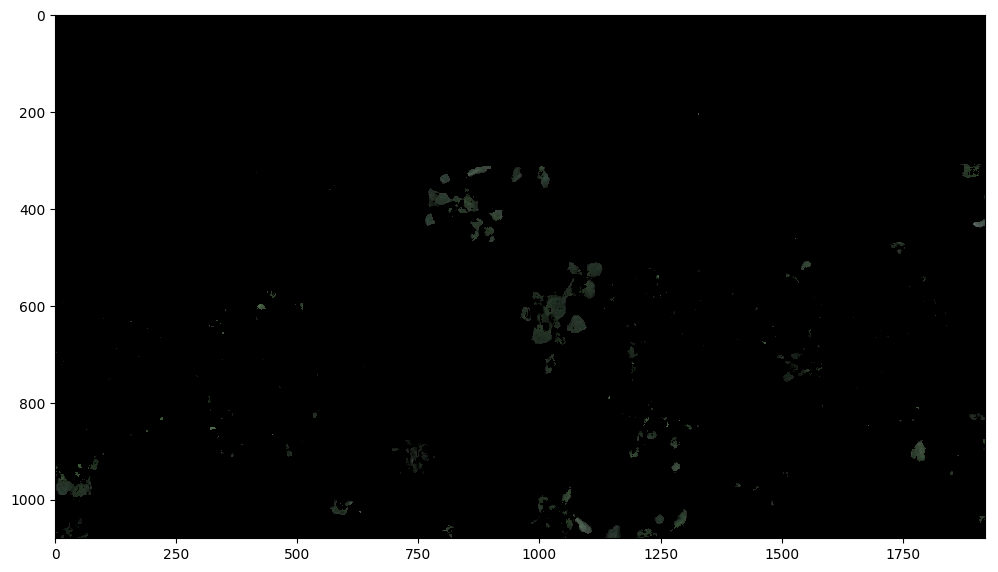

In [144]:
chosen_image = np.random.choice(images)
print(chosen_image)
image = cv2.imread("kinect_images/"+chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);
plt.show()
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def mask_plant(hsv_image):
    plant_high = (160,200,200)
    plant_low = (40,1,1)
    plant_mask = cv2.inRange(hsv_image, plant_low, plant_high)
    return plant_mask

print("imaged masked to include only plant material")
plant_result = cv2.bitwise_and(image,image,mask=mask_plant(hsv_image))
plt.imshow(plant_result)
plt.show();

def mask_crop(hsv_image):
    crop_high = (160,200,200)
    crop_low = (40,100,1)
    crop_mask = cv2.inRange(hsv_image, crop_low, crop_high)
    return crop_mask

print("image masked to differentiate between the crop_0 and other plants")
crop_result = cv2.bitwise_and(image,image,mask=mask_crop(hsv_image))
plt.imshow(crop_result);
plt.show()

def mask_weeds(hsv_image):
    weeds_high = (160,100,200)
    weeds_low = (55,1,1)
    weed_mask = cv2.inRange(hsv_image, weeds_low, weeds_high)
    return weed_mask

print("image masked to differentiate between the weeds, and other crops except crop_2")
weed_result = cv2.bitwise_and(image,image,mask=mask_weeds(hsv_image))
plt.imshow(weed_result);
plt.show()

For crop_0 and crop_1 colour can be used to quite easily seperate weeds from crops. However crop_2 is very similar in colour to the weeds and cannot be classified easily with this method. As for this project the perception task was not chosen for specialisation crop_2 can be ignored, as a result the use of colour for both segmentation and classification is a reasonable selection for a minimum viable prototype for this assignment. Colour segmentation and classification will not be robust to changes in lighting conditions, so this choice does exploit the simplicity of a simulated environment.

The masking of crop_0 is very clean, however for crop_1 there are some artifacts of the crop left in the weed images. The artifacts are small in size and it should be possible to remove them in post-processing.

In [145]:
def imshow_components(labels_im,coordinates_to_display=None):
    """
    following this stackoverflor answer https://stackoverflow.com/a/46442154 for a colour coded
    image of labels_im.
    """
    # Map component labels to hue val
    label_hue = np.uint8(179*labels_im/np.max(labels_im))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    if coordinates_to_display is not None:
        for coord in coordinates_to_display:
            labeled_img = cv2.circle(labeled_img, tuple(coord), radius=10, color=(255, 255, 255), thickness=3)
    

    return labeled_img        

In [146]:
grayscale_image = cv2.cvtColor(weed_result,cv2.COLOR_RGB2GRAY)
threshold_image = cv2.threshold(grayscale_image,1,255, cv2.THRESH_BINARY)[1] 
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(threshold_image)

def remove_small_clusters(labels_im,stats,centroids,min_num_pixels=60):
    """
    removes labels which have an area less than min_num_pixels. Returns labels_im, stats 
    and centroids for the image with labels corrected after the removal of small clusters so that labels
    in the image still correspond to the index of stats or centroids.
    """
    new_label_index = 0
    removed_indices = []
    for label in range(len(stats)):
        #remove labels if they have an area less than min_num_pixels 
        if stats[label][4] < min_num_pixels: 
            labels_im[labels_im==label] = 0 #set to background.
            removed_indices.append(label)    
        else:
        #for labels with area greater than min_num_pixels the label is updated so that they will correspond to 
        #the new index of stats and centroids  
            labels_im[labels_im==label] = new_label_index
            new_label_index += 1
            
    #stats and centroids arrays are updated to remove references for filtered labels.
    new_stats = np.delete(stats,removed_indices,axis=0)
    new_centroids = np.delete(centroids,removed_indices,axis=0)         
    return labels_im, new_stats, new_centroids

def kmeans_centroids(centroids,num_clusters,labels_im=None):
    """
    Applying kmeans clustering to the centroids of connected components, returns the centroids of the k clusters.
    If labels_im is given, it will be updated so that the labels and indices reflect the new clusters
    TODO tune parameters, num clusters etc for kmeans.
    """    
    #the centroid at index 0 is for the background and is discarded
    compactness,cluster_labels,cluster_centroids = cv2.kmeans(centroids[1:].astype('float32'),K=num_clusters,bestLabels=None,
                                                              criteria=(cv2.TERM_CRITERIA_EPS, 10, 0.1),
                                                              attempts=100,flags=cv2.KMEANS_RANDOM_CENTERS)
    if labels_im is not None:
        for index,cluster_label in enumerate(cluster_labels):
            labels_im[labels_im==index+1] = cluster_label + 1 #index 0 is used for background 
        return cluster_centroids,labels_im
    else:
        return cluster_centroids

plain image


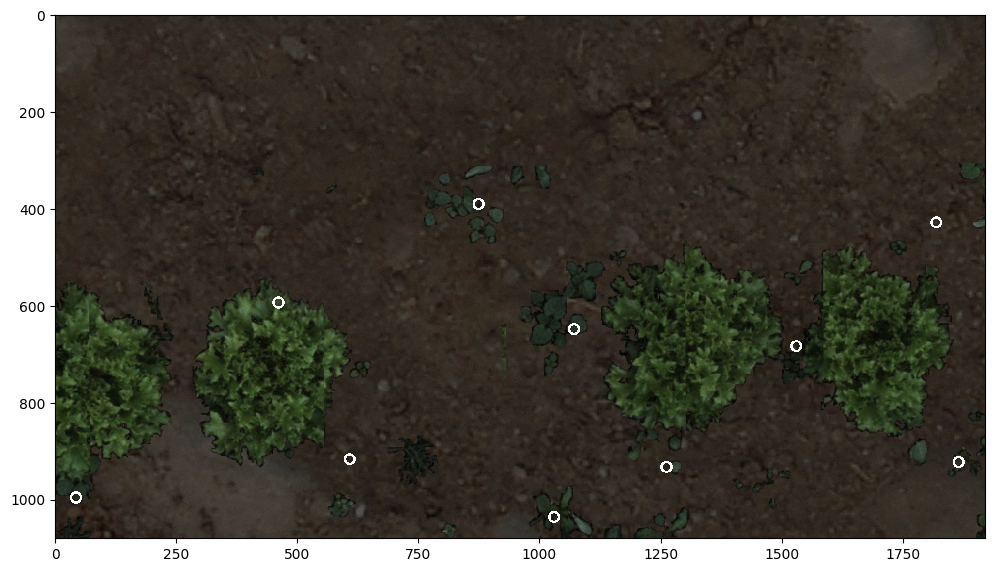

labels_im before filtering. The number of labels is: 398


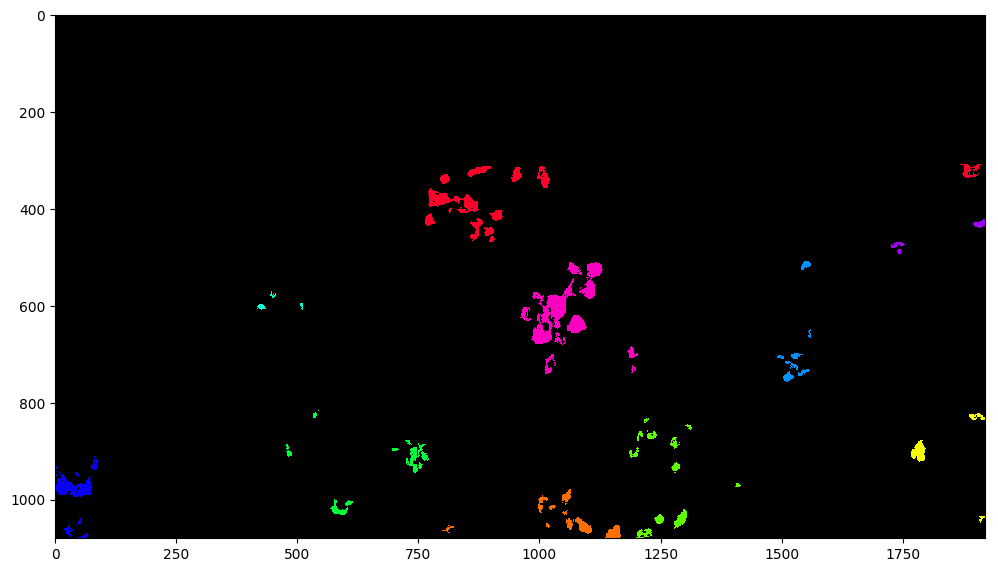

small clusters removed. The number of labels is: 74


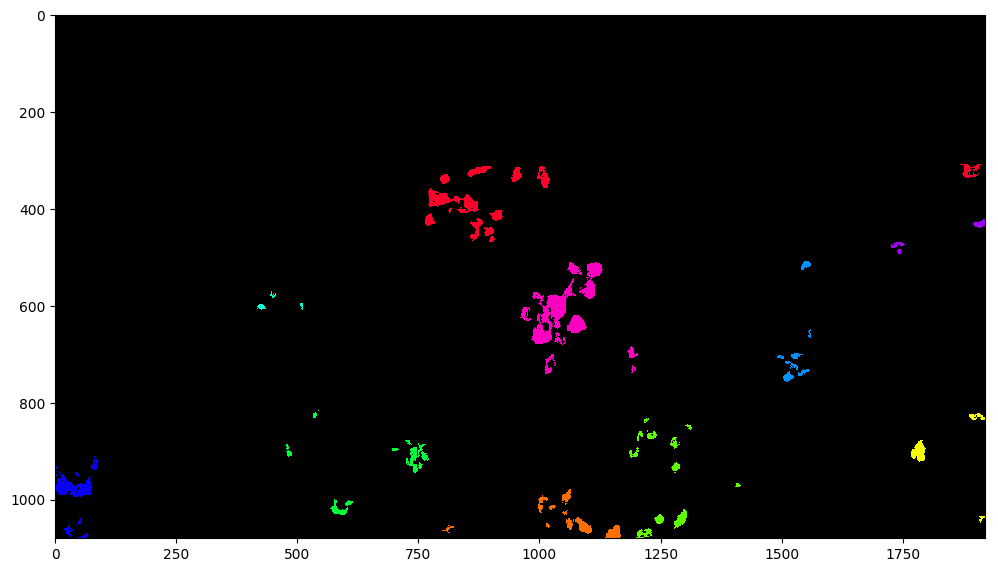

after k means clustering. The number of labels is: 10


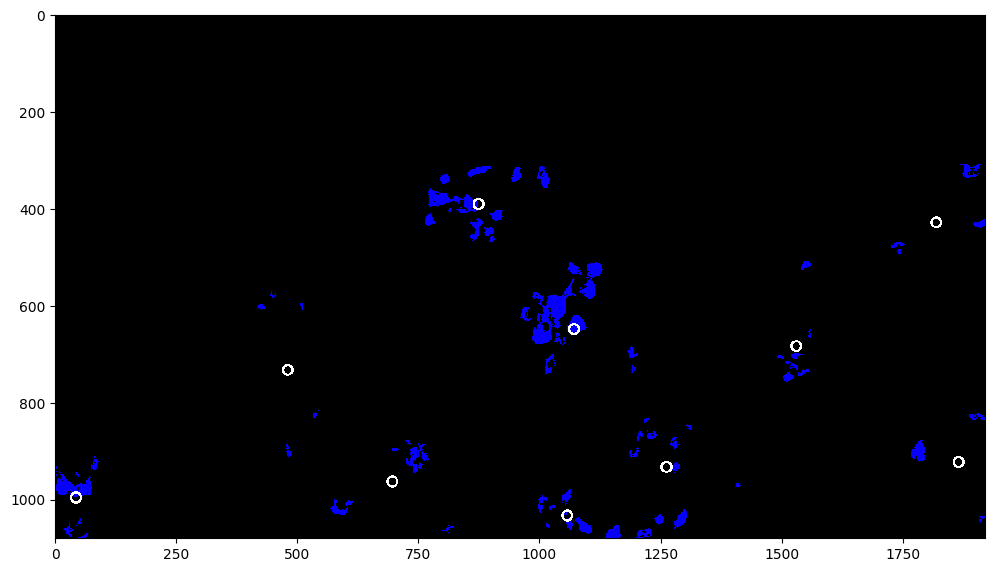

original image, with weed targets from kmeans clustering


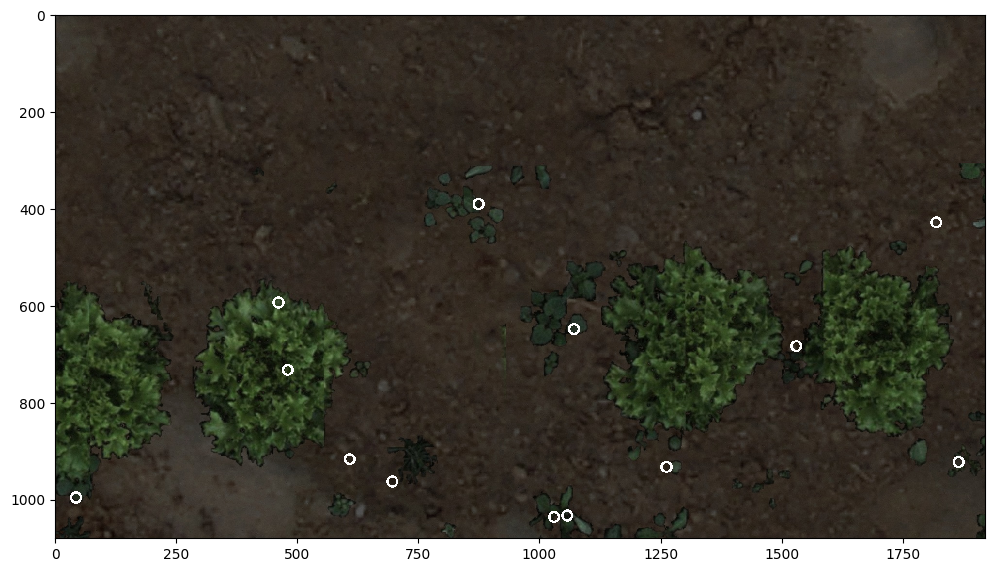

In [148]:
print("plain image")
plt.imshow(image);
plt.show()

print("labels_im before filtering. The number of labels is:",num_labels)
plt.imshow(imshow_components(labels_im));
plt.show()

labels_im,stats,centroids = remove_small_clusters(labels_im,stats,centroids)
print("small clusters removed. The number of labels is:",stats.shape[0])
plt.imshow(imshow_components(labels_im));
plt.show()

cluster_centroids,labels_im = kmeans_centroids(centroids,num_clusters=10,labels_im=labels_im)
print("after k means clustering. The number of labels is:",cluster_centroids.shape[0])
plt.imshow(imshow_components(labels_im,cluster_centroids));
plt.show()

print("original image, with weed targets from kmeans clustering")
for coord in cluster_centroids:
    targets_img = cv2.circle(image, tuple(coord), radius=10, color=(255, 255, 255), thickness=3)
plt.imshow(targets_img);
plt.show()


## Below are several visualisations that were used to aid in the choice of mask.
following this tutorial https://realpython.com/python-opencv-color-spaces/ for segmentation by colour

In [260]:
"""
3d plots for colour space investigating.
code ripped from https://realpython.com/python-opencv-color-spaces/
"""
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

def plot_colour_space(image,labels):
    split_image = cv2.split(image)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    pixel_colors = image.reshape((np.shape(image)[0]*np.shape(image)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    axis.scatter(split_image[0].flatten(), split_image[1].flatten(), split_image[2].flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    plt.show()

RGB colour space of image


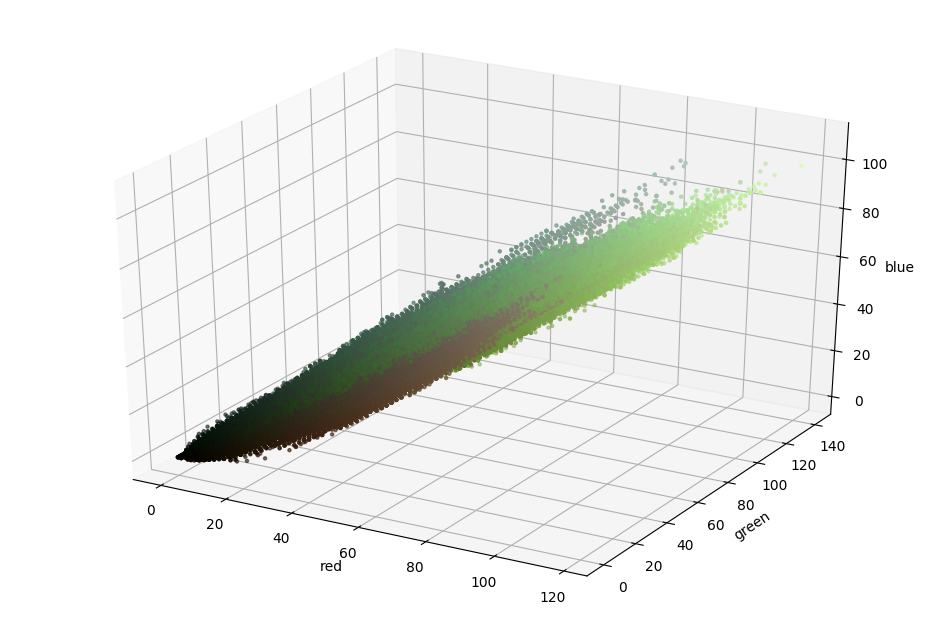

HSV colour space of image


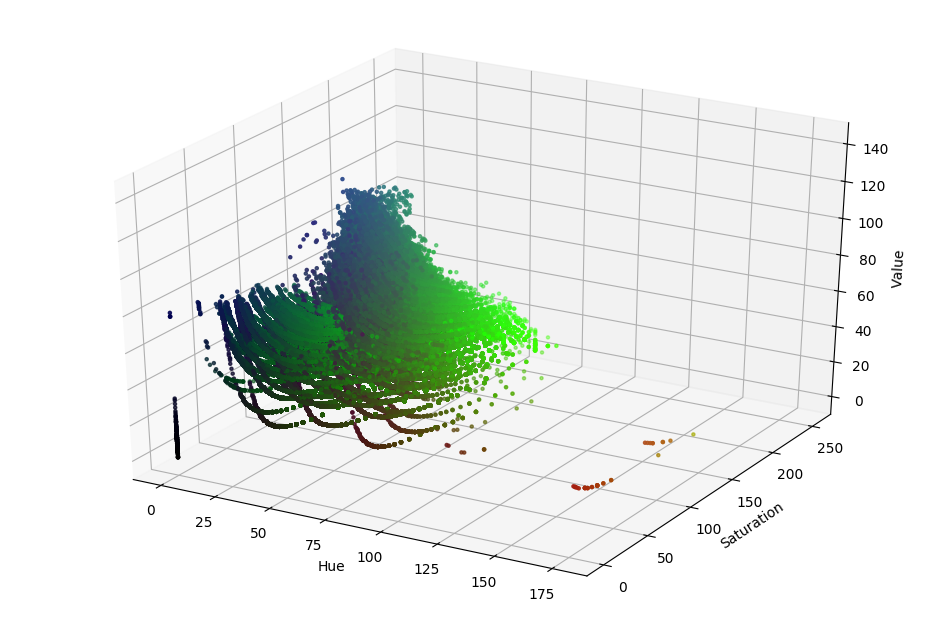

In [137]:
print("RGB colour space of image")
plot_colour_space(image,['red','green','blue'])

HSV colour space of image


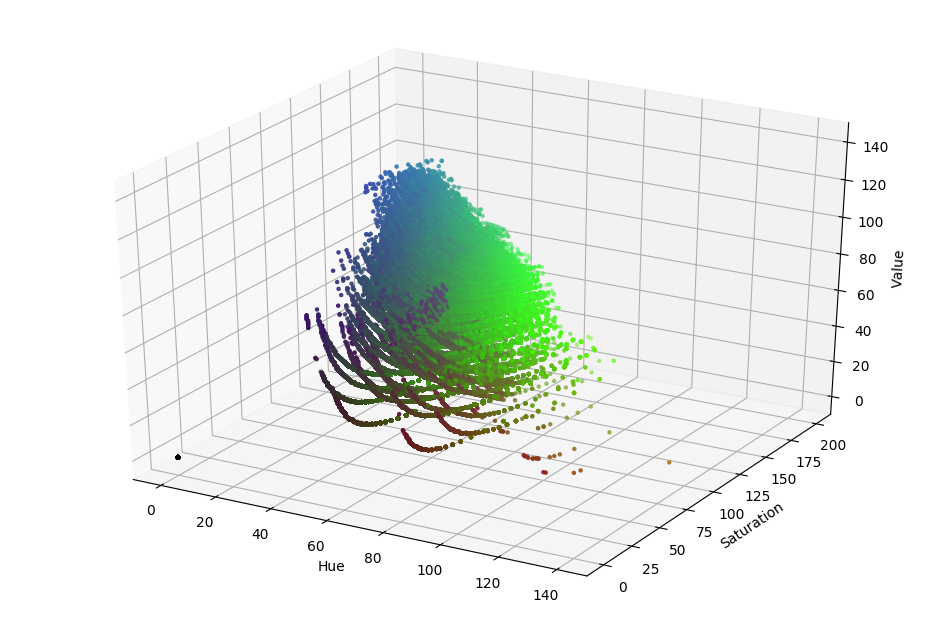

In [261]:
print("HSV colour space of image")
hsv_plant_result = cv2.cvtColor(plant_result,cv2.COLOR_RGB2HSV )
plot_colour_space(hsv_plant_result,['Hue','Saturation','Value'])

In [262]:
from matplotlib.colors import hsv_to_rgb
def plot_colour(colour):
    square = np.full((10, 10, 3), colour, dtype=np.uint8) / 255.0
    fig = plt.figure(figsize=(2,2))
    plt.imshow(hsv_to_rgb(square))
    plt.show()